# Computation Final Project

In [1]:
from cycler import cycler
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rc('axes',prop_cycle=(cycler('color', ['#003a7d','#d83034','#98c127','#f9e858','#ff9d3a','#008dff', '#ff73b6', '#c701ff'])))

## Question 1. Using Chat-GPT to generate code

### Homework 1, Problem 2 - generating Hernquist positions and velocities

For this problem, I uploaded all text from Problem 2 into Chat-GPT with the initial prompt "Only generate the positions and velocities for this question, not the efficiency tests." The initial solution was not correct. I re-explained the prompt in my own terms, emphasizing where the providing answer was going wrong. The corrected solution was even worse - there were many semantic errors. Then I re-asked the question, outlining my original answer, and was given the code below. There are again many semantic errors, which when reported back to Chat-GPT give shockingly even worse solutions - calling functions that do not exist. I tried many suggestions and fixes, but without coding the (already known correct) answer myself it would not give a working solution. This could provide a starting point to work from, but I think that would be more confusing than helpful.

The provided code has an overall cohesive idea (which was prompted by user), but completely misses on execution. It does sample positions correctly, but gets quite confused in generating and using the bounding function - especially with the negative/positive signs. It provides a bounding function, but guesses that the distribution function peaks in the middle and therefore uses that as an upper bound. The notion of energy as positive or negative is not consistent, and therefore leads to negative sums in square roots. 

Overall, it was really difficult to get Chat-GPT to give code that works (even just runs) for this problem. I think because this problem involves coming up with a bounding function (generating an idea) and also keeping track of notion across different platforms (the energy notion from Hernquist disagrees with the homework prompt). 

/var/folders/9n/z5456p4n4k71bdvhgh74hrmr0000gq/T/ipykernel_69328/674113089.py:37: RuntimeWarning: invalid value encountered in sqrt
  return fE(phir / 2) * np.sqrt(phir - E)


OverflowError: Range exceeds valid bounds

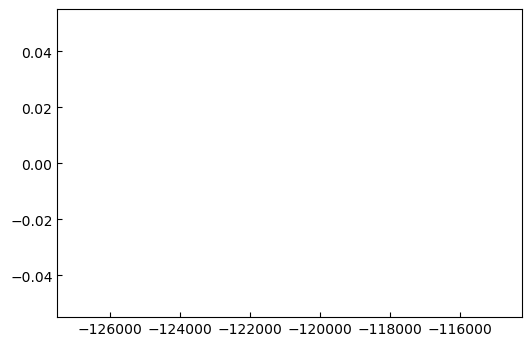

In [82]:
import numpy as np
from scipy.integrate import quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Physical constants and halo parameters
G = 4.302e-6  # gravitational constant in kpc * (km/s)^2 / Msun
M = 1e12      # total mass in Msun
a = 35.0      # scale radius in kpc
N = int(1e6)  # number of particles

# Hernquist potential and distribution function
def phi(r):
    return -G * M / (r + a)

def fE(E):  # from Eq. 17 of Hernquist (1990)
    Q = E / (-phi(0))  # normalized energy
    if np.any(Q <= 0) or np.any(Q > 1):
        return 0.0
    factor = (1 / (np.sqrt(2) * (2 * np.pi)**3 * (G * M / a)**(3/2)))
    numerator = 3 * np.arcsin(np.sqrt(Q)) + np.sqrt(Q * (1 - Q)) * (1 - 2 * Q) * (8 * Q**2 - 8 * Q - 3)
    return factor * numerator / (Q**2.5)

# Generate positions already (assuming spherical Hernquist profile)
def sample_positions(N):
    u = np.random.uniform(size=N)
    r = a * u**2 / (1 - u**2)  # inverse CDF of Hernquist profile
    theta = np.arccos(1 - 2 * np.random.uniform(size=N))
    phi_angle = 2 * np.pi * np.random.uniform(size=N)
    x = r * np.sin(theta) * np.cos(phi_angle)
    y = r * np.sin(theta) * np.sin(phi_angle)
    z = r * np.cos(theta)
    return np.vstack((x, y, z)).T, r

# Bounding function: overestimate of f(E) sqrt(phi - E)
def bounding_function(E, phir):
    return fE(phir / 2) * np.sqrt(phir - E)

def sample_velocity_magnitude(phir):
    # Upper limit for energy: E_max = phi(r)
    E_max = phir
    # Lower limit is zero (E=0 means unbound)
    E_vals = np.linspace(0, E_max, 500)
    f_vals = np.array([bounding_function(E, phir) for E in E_vals])
    plt.plot(E_vals, f_vals)
    integral = np.trapz(f_vals, E_vals)

    while True:
        # Step 1: sample area under bounding function
        A = np.random.uniform(0, integral)
        cumulative = np.cumsum(f_vals) * (E_max / len(E_vals))
        energy_idx = np.searchsorted(cumulative, A)
        if energy_idx >= len(E_vals):
            continue
        E_trial = E_vals[energy_idx]
        
        # Step 2: sample another uniform between 0 and bounding_function(E)
        f_bound = bounding_function(E_trial, phir)
        y = np.random.uniform(0, f_bound)
        if y < fE(E_trial) * np.sqrt(phir - E_trial):
            # Accept
            v = np.sqrt(2 * (phir - E_trial))
            return v

def sample_velocities(positions, radii):
    velocities = np.zeros_like(positions)
    for i in range(len(radii)):
        r = radii[i]
        phir = phi(r)
        v_mag = sample_velocity_magnitude(phir)
        # Random 3D direction
        theta = np.arccos(1 - 2 * np.random.rand())
        phi_angle = 2 * np.pi * np.random.rand()
        vx = v_mag * np.sin(theta) * np.cos(phi_angle)
        vy = v_mag * np.sin(theta) * np.sin(phi_angle)
        vz = v_mag * np.cos(theta)
        velocities[i] = [vx, vy, vz]
        if i % 10000 == 0:
            print(f"Sampled {i}/{N} velocities")
    return velocities

# MAIN execution
positions, radii = sample_positions(N)
velocities = sample_velocities(positions, radii)

# Save to file or continue with analysis
#np.savez("hernquist_particles.npz", positions=positions, velocities=velocities)

# Optional: radial velocity dispersion test
def radial_velocity_dispersion(positions, velocities, n_bins=50):
    r = np.linalg.norm(positions, axis=1)
    vr = np.sum(positions * velocities, axis=1) / r  # radial component
    bins = np.logspace(np.log10(np.min(r)+1e-2), np.log10(np.max(r)), n_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    dispersion = np.zeros(n_bins - 1)
    for i in range(n_bins - 1):
        mask = (r >= bins[i]) & (r < bins[i+1])
        if np.any(mask):
            dispersion[i] = np.sqrt(np.mean(vr[mask]**2))
    return bin_centers, dispersion

r_bins, disp = radial_velocity_dispersion(positions, velocities)
plt.loglog(r_bins, disp)
plt.xlabel('r [kpc]')
plt.ylabel(r'$\sigma_r$ [km/s]')
plt.title("Radial Velocity Dispersion")
plt.grid(True)
plt.show()

### Homework 2, Problem 1 - 4th order Kepler RK

Once again, I uploaded the full homework prompt (up until adaptive timestep) into Chat-GPT and asked to complete for e = 0.96. The initial resulting code is below, it compiles and runs. The code works correctly! It uses some different design choices that make it less easy to interpret - not saving the timesteps, not passing the time into the derivates for RK4, ... The resulting errors are slightly different from mine, but not too far off.

I think Chat-GPT succeeds at this problem because both the problem (Kepler) and the solution (4th order RK) are well-documented online and need no generating of ideas to solve. There is only implementing a problem and a solution, no need to come up with the solution. 

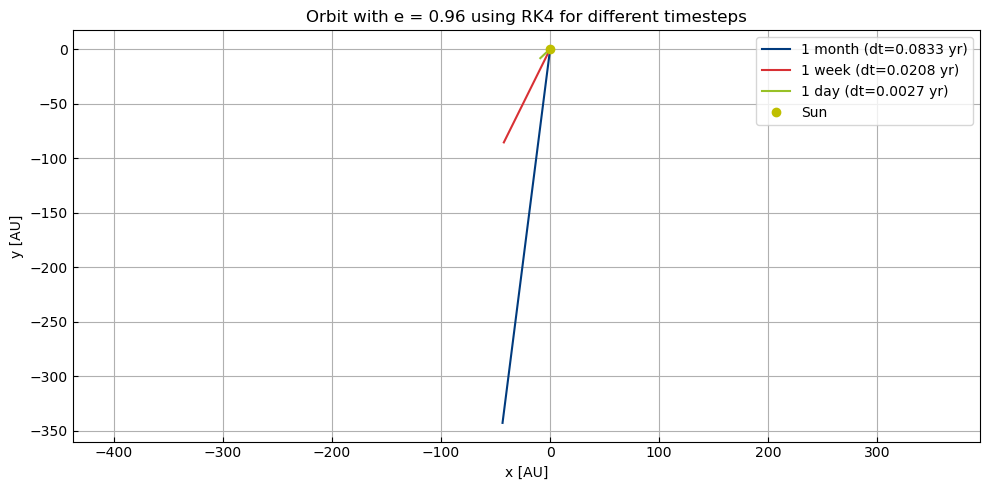

Error Summary (e = 0.96):
Timestep   dt [yr]    |Δr| [AU]       ΔE/E      
1 month    0.08333    3.45465e+02     3.02401e+03
1 week     0.02083    9.55294e+01     2.32025e+02
1 day      0.00274    1.22802e+01     4.18969e+00


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 4 * np.pi**2  # AU^3 / yr^2 / Msun
M = 1.0           # Msun
a = 1.0           # AU
e = 0.96
rp = a * (1 - e)
vp = np.sqrt(G * M / a * (1 + e) / (1 - e))

# Initial conditions at pericenter
r0 = np.array([0.0, rp])
v0 = np.array([-vp, 0.0])
y0 = np.concatenate((r0, v0))

# Time array
T = 1.0  # 1 year
timesteps = {
    "1 month": 1/12,
    "1 week": 1/48,
    "1 day": 1/365.25,
}

# Define derivatives for RK4
def derivatives(y):
    r = y[:2]
    v = y[2:]
    r_mag = np.linalg.norm(r)
    a = -G * M * r / r_mag**3
    return np.concatenate((v, a))

# 4th-order Runge-Kutta integrator
def run_rk4(y0, dt, T):
    N = int(T / dt)
    y = np.zeros((N + 1, 4))
    y[0] = y0
    for i in range(N):
        k1 = dt * derivatives(y[i])
        k2 = dt * derivatives(y[i] + 0.5 * k1)
        k3 = dt * derivatives(y[i] + 0.5 * k2)
        k4 = dt * derivatives(y[i] + k3)
        y[i + 1] = y[i] + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y, N

# Total energy function
def total_energy(y):
    r = y[:, :2]
    v = y[:, 2:]
    r_mag = np.linalg.norm(r, axis=1)
    v_mag2 = np.sum(v**2, axis=1)
    KE = 0.5 * v_mag2
    PE = -G * M / r_mag
    return KE + PE

# Run and evaluate each timestep
errors = []

plt.figure(figsize=(10, 5))

for i, (label, dt) in enumerate(timesteps.items()):
    y, N = run_rk4(y0, dt, T)
    r = y[:, :2]
    energy = total_energy(y)
    
    final_pos_error = np.linalg.norm(r[-1] - y0[:2])
    energy_error = abs(energy[-1] - energy[0]) / abs(energy[0])
    errors.append((label, dt, final_pos_error, energy_error))
    
    plt.plot(r[:, 0], r[:, 1], label=f"{label} (dt={dt:.4f} yr)")

# Plot orbits
plt.plot(0, 0, 'yo', label="Sun")
plt.title("Orbit with e = 0.96 using RK4 for different timesteps")
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.axis("equal")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print error summary
print("Error Summary (e = 0.96):")
print(f"{'Timestep':<10} {'dt [yr]':<10} {'|Δr| [AU]':<15} {'ΔE/E':<10}")
for label, dt, dr, de in errors:
    print(f"{label:<10} {dt:<10.5f} {dr:<15.5e} {de:<10.5e}")


### Hogg & Foreman-Mackey, problem 2 - Simple MH-MCMC sampler

Once again, I copied the problem into Chat-GPT and asked it to create a solution. The code runs and provides the correct answer. It's interesting that the provided solution has density in log-space. Most often, MH-MCMC walkers step through the parameter space in ln-steps. The code provided is setup to easily change to these steps, unlike the class and my initial writing of this code. 

I think Chat-GPT succeeds at writing this code because it is again a well-documented, fairly simple problem and solution. There are many articles, outlines, and discussions online from which it can pull from. This question does not ask for any new creativity or novel ideas. 

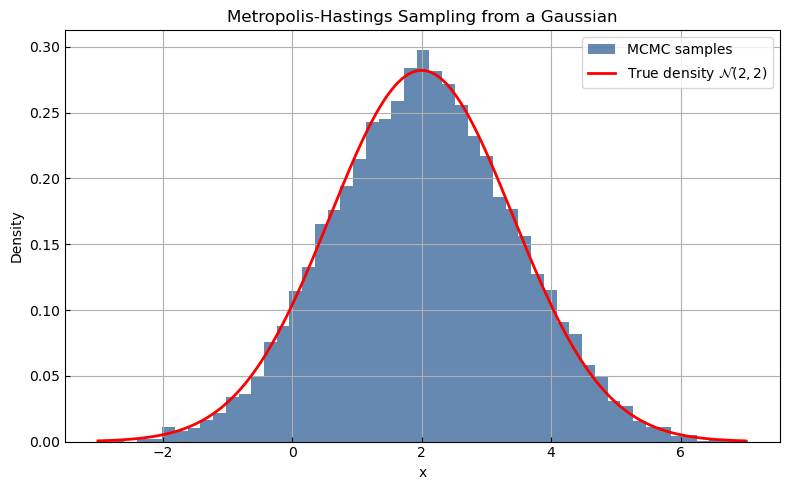

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Target density: N(2, 2)
def log_p(x):
    return -0.5 * ((x - 2)**2 / 2)  # log of Gaussian with mean=2, var=2

# MH sampler
def metropolis_hastings(log_p, proposal_std=1.0, x0=0.0, n_steps=20000):
    samples = np.zeros(n_steps)
    x = x0
    for i in range(n_steps):
        x_new = np.random.normal(x, proposal_std)
        log_alpha = log_p(x_new) - log_p(x)
        if np.log(np.random.rand()) < log_alpha:
            x = x_new
        samples[i] = x
    return samples

# Run sampler
np.random.seed(42)
samples = metropolis_hastings(log_p, proposal_std=1.0, x0=0.0, n_steps=20000)

# Plot
x_grid = np.linspace(-3, 7, 500)
true_pdf = norm.pdf(x_grid, loc=2, scale=np.sqrt(2))

plt.figure(figsize=(8, 5))
plt.hist(samples, bins=50, density=True, alpha=0.6, label="MCMC samples")
plt.plot(x_grid, true_pdf, 'r-', lw=2, label="True density $\\mathcal{N}(2, 2)$")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Metropolis-Hastings Sampling from a Gaussian")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Final Remarks

I think using Chat-GPT (and other LLMs) have a steep learning curve for how to input questions to get the best results. This is not something I've totally figured out - it might be possible to get a successful answer to the first problem, but I could not think of better inputs. Without knowing the answer (or being able to manually check), it's really difficult to get LLM answers that you feel confident about. I think Chat-GPT is good at generating code for well-documented problems with well-documented solutions. It cannot come up with new ideas specific to a given problem or apply ideas to a new problem. Additionally, when pushed to explain the code design, the reasoning behind it, or told about errors in the code, it often breaks down. In my experience, it really only works when 

## Question 2 - Gravity calculation with periodic conditions

The main change is this calculation is right before directly calculating the acceleration. For each particle in the inner loop, we have to check if the periodic (flipped by 100) location is closer than the original location in each dimension. So if one particle is at x=20 and we are calculating the force from a particle at x=90, it's actually at x=10 (the flipped location in this dimension). We check this for each dimension, which adds a bit of time to the overall calculation but not significant. It took 2-3 times longer to complete.

To do this with a KDTree, I think you would need to search multiple times with the flipped location images. That way you are calculating the force from particles near it but across the boundary. This will count the force from far-away particles multiple times, but the force is expected to be small and only roughly estimated. You could stop counting up the force from far-particles after the first KDTree search with the original particle location. 

In [77]:
# translates python code into machine code to go faster
from numba import jit


# Adapted from Homework 3 -- now has periodic boundary conditions

# Caclulates acceleration of random particles in three dimensions due to gravity
# INPUT: npart x 3 length array of x,y,z coordinates of particles
# RETURNS: total force on particles in x,y,z directions
# note: instead of doing two full for-loops, we use the fact that force on particle a from b = negative force on particle b from a
@jit
def direct_accel(rand_vec):
    
    num_part = len(rand_vec)

    # Equal to acceleration since using unit masses
        # This naming makes more sense in my brain
    forces_x = np.zeros(num_part)
    forces_y = np.zeros(num_part)
    forces_z = np.zeros(num_part)

    # Loop over each particle
    for curr_part in range(num_part):

        # Loop over remaining particles
            # already calculated force from particles earlier in array, don't need to recalculate
        for j in np.arange(curr_part+1, num_part, 1):

            # NEW CODE IMPLEMENTATION ---
            # check periodic boundary conditions - if the periodic distance is closer than original, use that 
            r_nearest = rand_vec[j] # where to save final position
            
            pos_flipped = np.array([100,100,100]) - rand_vec[j] # flip particle to other side in each dimension
            for idx in range(3):
                # if unflipped distance is greater than flipped distance, use flipped distance to calculate
                dist_orig = np.abs(rand_vec[curr_part][idx] - rand_vec[j][idx]) 
                dist_flipped = np.abs(rand_vec[curr_part][idx] - pos_flipped[idx])
                if (dist_orig > dist_flipped):
                    r_nearest[idx] = pos_flipped[idx] 
                    
            # calculate force between two particles
            r = r_nearest - rand_vec[curr_part]
            dist = (r[0]**2 + r[1]**2 + r[2]**2)**(1/2)
            curr_force = 1/dist**3 * r

            # save forces, using newton's third law
            forces_x[curr_part] += curr_force[0]
            forces_x[j] -= 1*curr_force[0]

            forces_y[curr_part] += curr_force[1]
            forces_y[j] -= 1*curr_force[1]

            forces_z[curr_part] += curr_force[2]
            forces_z[j] -= 1*curr_force[2]

    # divide by mass here, if not unit mass
    return forces_x, forces_y, forces_z


# Driver function that calculates acceleration of particles
# INPUT: number of particles, if using direct method
# RETURNS: acceleration vector
def calculate_accel(npar):

    # Make 3D position vector uniform in x,y,z
    new_randvec=my_randState.rand(npar,3)*100

    start_time = time.time()
    accel_x, accel_y, accel_z = direct_accel(new_randvec)
    end_time = time.time()
    print("Time for direct method with N =", npar, ':', end_time-start_time)
    
    return [accel_x, accel_y, accel_z]


In [81]:
# Driver ---

my_randState=np.random.RandomState(seed=539271)
npart = 100000
a = calculate_accel(npart)

# Compared to 267.35 with no periodic boundary conditions 

Time for direct method with N = 100000 : 733.7297842502594
